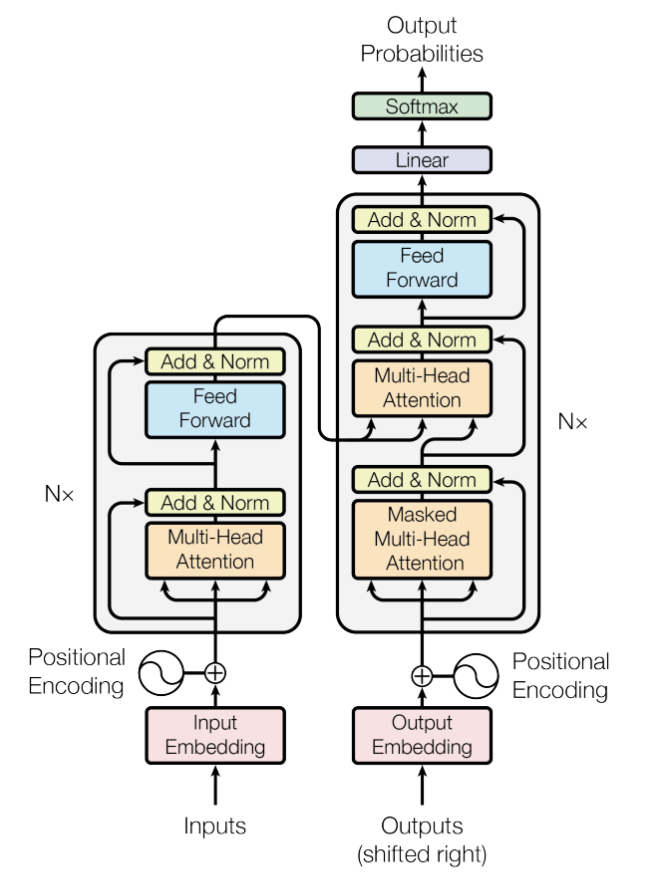

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-06-19 02:04:14--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-06-19 02:04:15 (24.0 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 1000 characters
print(text[:1000])
print(set(text))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("Hello world!"))
print(decode(encode("Hello world")))

[20, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42, 2]
Hello world


In [ ]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

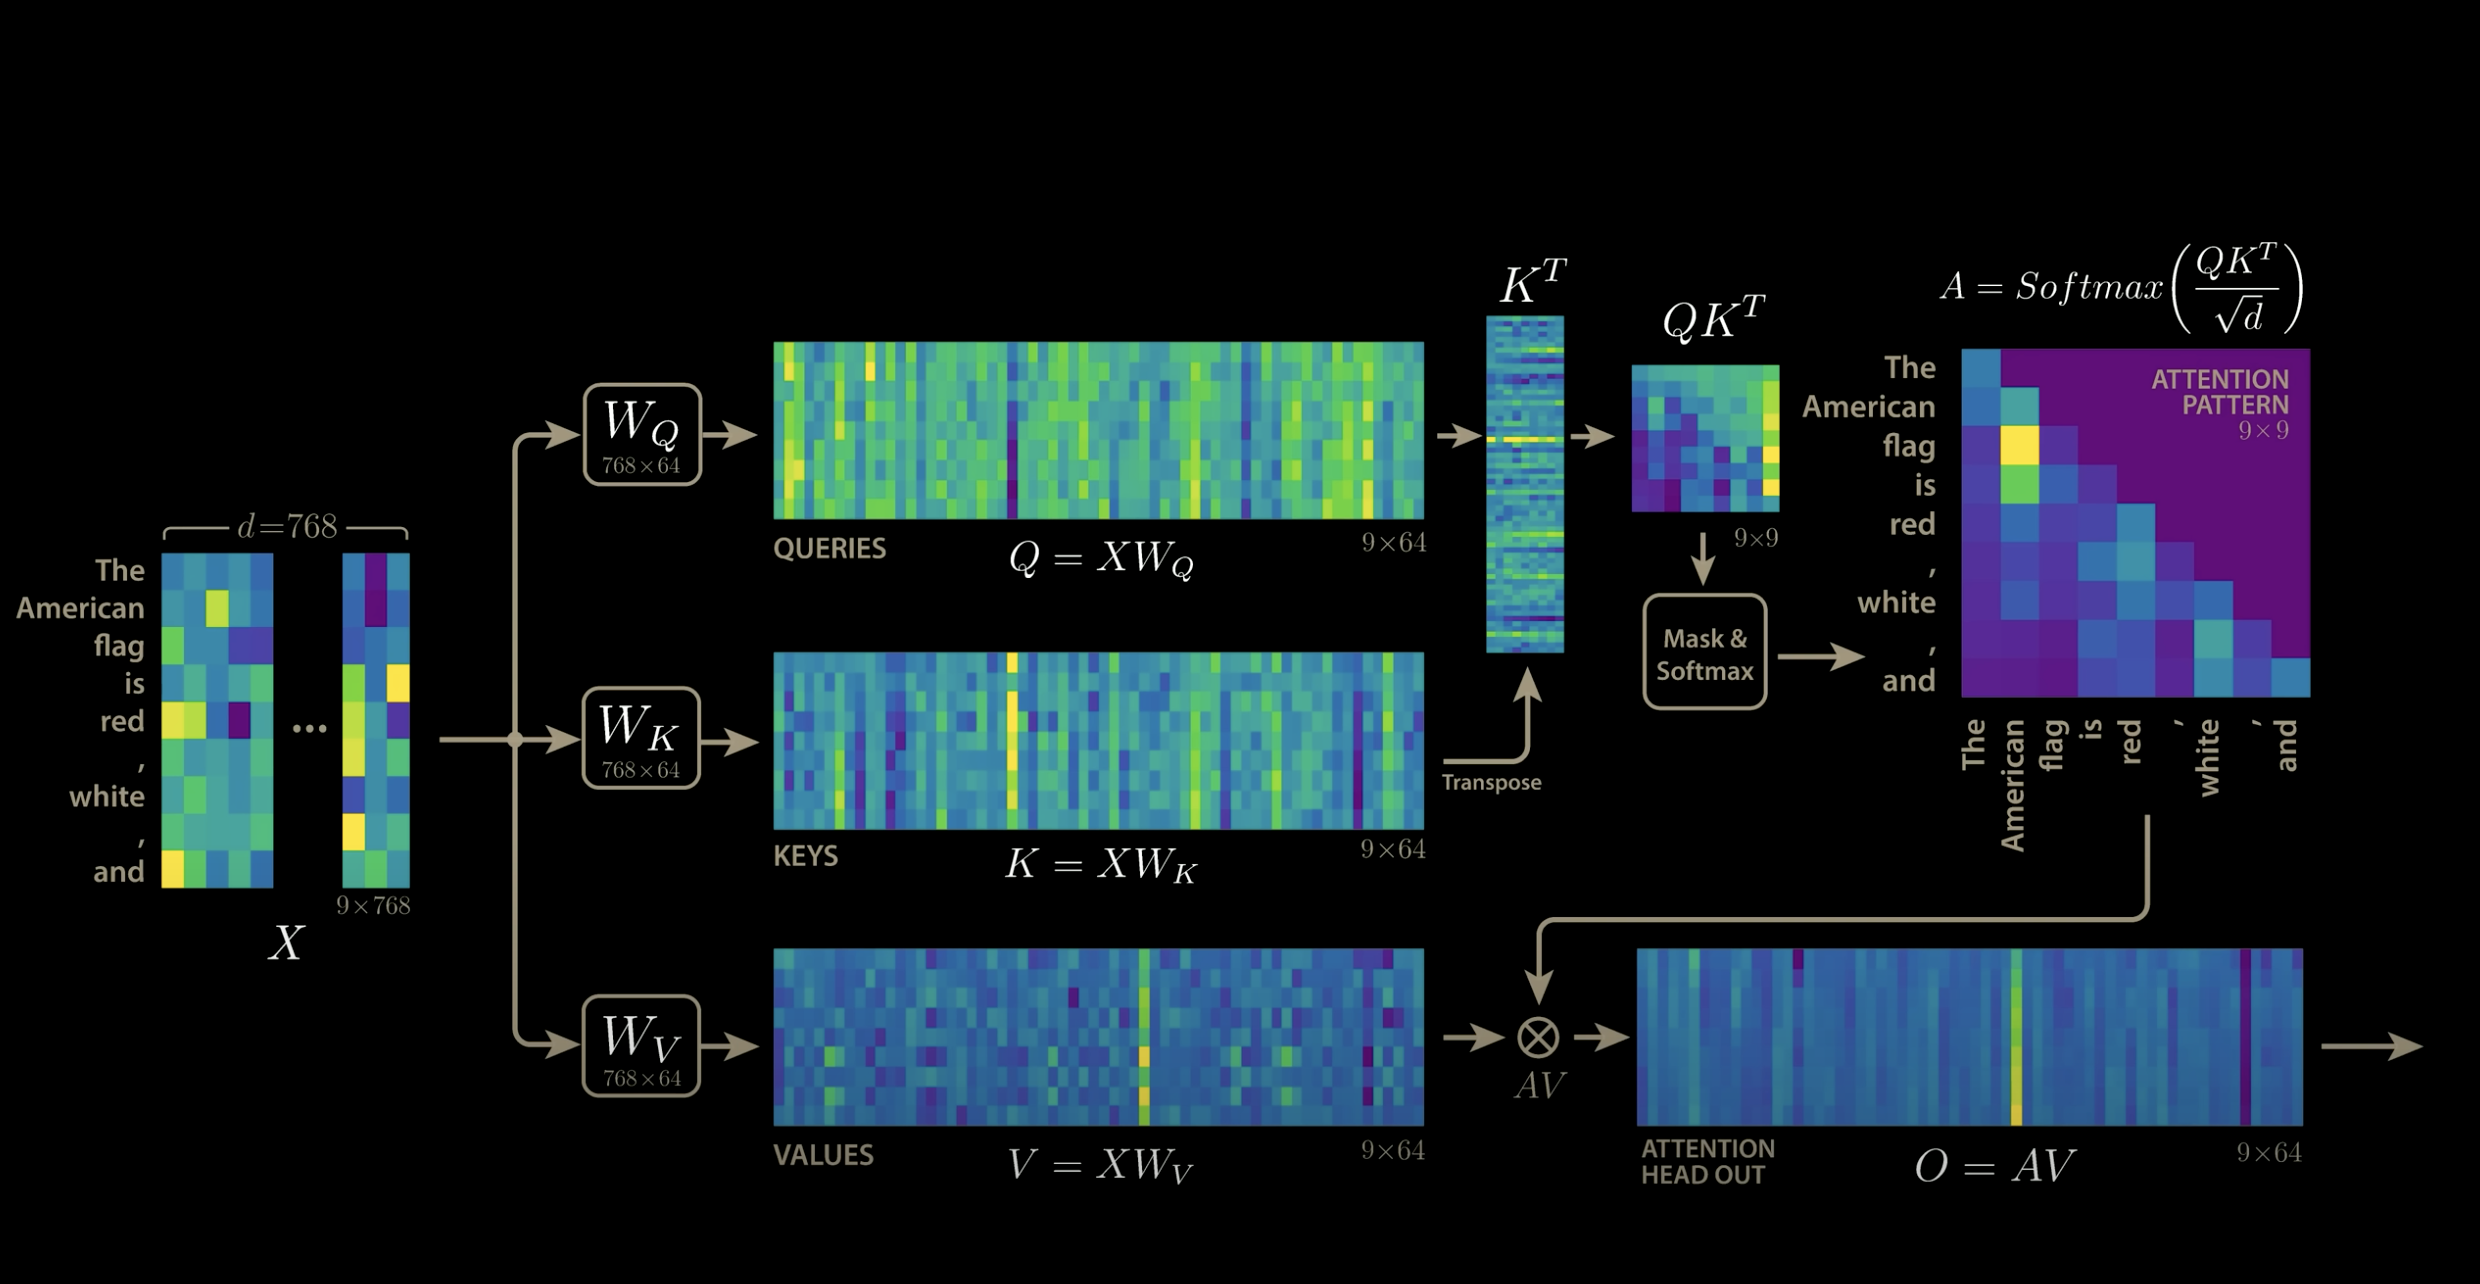

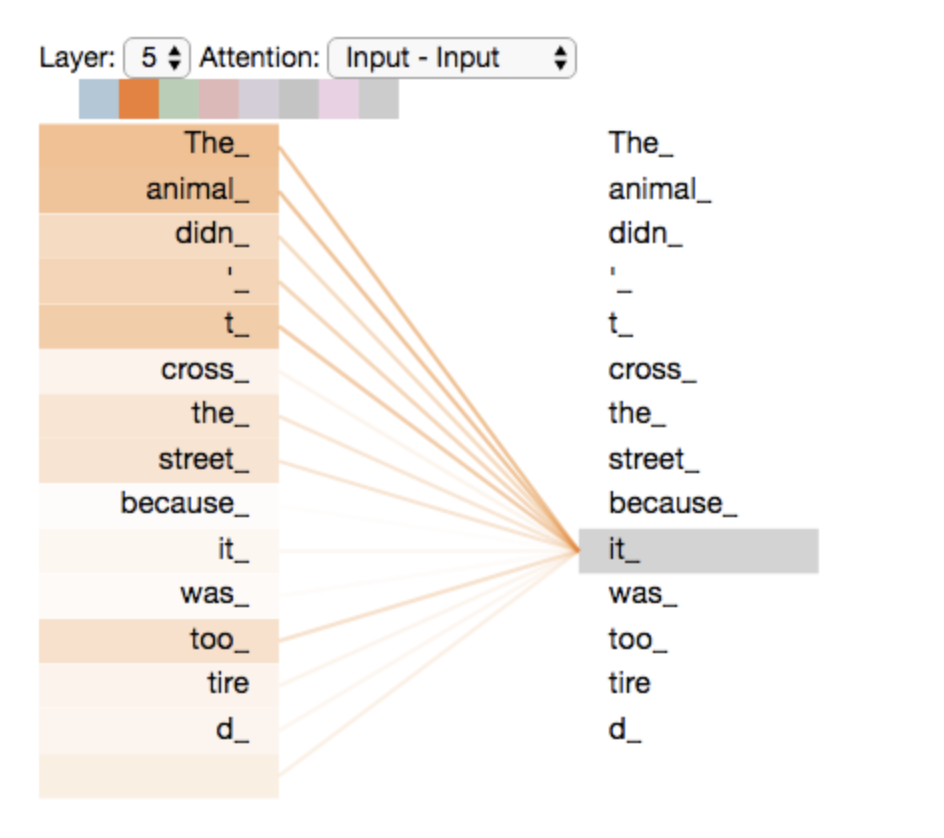

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class NanoGpt(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = NanoGpt()
print(model)
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


NanoGpt(
  (token_embedding_table): Embedding(65, 64)
  (position_embedding_table): Embedding(32, 64)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2): Lay

In [ ]:
print([n for n, p in model.named_parameters() if p.requires_grad])

['token_embedding_table.weight', 'position_embedding_table.weight', 'blocks.0.sa.heads.0.key.weight', 'blocks.0.sa.heads.0.query.weight', 'blocks.0.sa.heads.0.value.weight', 'blocks.0.sa.heads.1.key.weight', 'blocks.0.sa.heads.1.query.weight', 'blocks.0.sa.heads.1.value.weight', 'blocks.0.sa.heads.2.key.weight', 'blocks.0.sa.heads.2.query.weight', 'blocks.0.sa.heads.2.value.weight', 'blocks.0.sa.heads.3.key.weight', 'blocks.0.sa.heads.3.query.weight', 'blocks.0.sa.heads.3.value.weight', 'blocks.0.sa.proj.weight', 'blocks.0.sa.proj.bias', 'blocks.0.ffwd.net.0.weight', 'blocks.0.ffwd.net.0.bias', 'blocks.0.ffwd.net.2.weight', 'blocks.0.ffwd.net.2.bias', 'blocks.0.ln1.weight', 'blocks.0.ln1.bias', 'blocks.0.ln2.weight', 'blocks.0.ln2.bias', 'blocks.1.sa.heads.0.key.weight', 'blocks.1.sa.heads.0.query.weight', 'blocks.1.sa.heads.0.value.weight', 'blocks.1.sa.heads.1.key.weight', 'blocks.1.sa.heads.1.query.weight', 'blocks.1.sa.heads.1.value.weight', 'blocks.1.sa.heads.2.key.weight', 'block

In [ ]:
print(decode(m.generate(context, max_new_tokens=1000)[0].tolist()))


Have! good.

KING GRET:
Hevens, is the is teesurn sweixtend
Servale bilet to his
As his gravents her nortune it my mmary.

Firsw; tharword broth!

HOMINIUS:
Ignortunned, and tkeep one ding some stands this sport-deny of
In in some an the last faithers clear so be,
this good that thou
With wastilveice. They disder, for untitous
Face, but I my wither sir thereful.

NESVERS OF YLorder Mady.

CORIONIUS:
Well, what thou stilk that wase suse.

PROMEONTER:

BOLINGHARENCE:
So all marward, my the contors, fI, hou gone the grove?

Seeme, if thou some.

HASTENouIA:
If too may Nease that, no you have
Toway, that mergted, cort, as art us accutity-borth,
Yet, but burnose you would, he fortunuriouteds of while desing.
Counter to dougbt,--hat they plaom rough what langes swars sualdless to befout to noth beneen livisher.

BENVOLIO:
To-Kitiry princ him, Ithal detch.

KING EDWARD IV:
Thou amion: my by yon a some that yoursed on the gative,
And some, fortuner, you bed few!
And It, becance Frenies, doth 

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor

# Load a pre-trained ViT model and feature extractor
model_name = 'google/vit-large-patch32-384'
processor = ViTImageProcessor.from_pretrained(model_name, do_rescale=False)
model = ViTForImageClassification.from_pretrained(model_name, attn_implementation='eager')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

In [ ]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


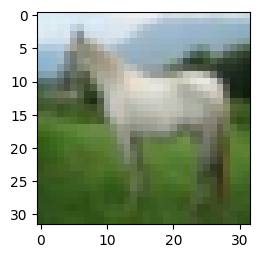

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.subplot(5, 5, 1)
plt.grid(False)
plt.imshow(x_train[152])
plt.show()

# Run an image through the pipline
inputs = processor(images=x_train[152], return_tensors="pt")
outputs = model(**inputs, output_attentions=True)

# Getting the attentions
attentions = outputs.attentions

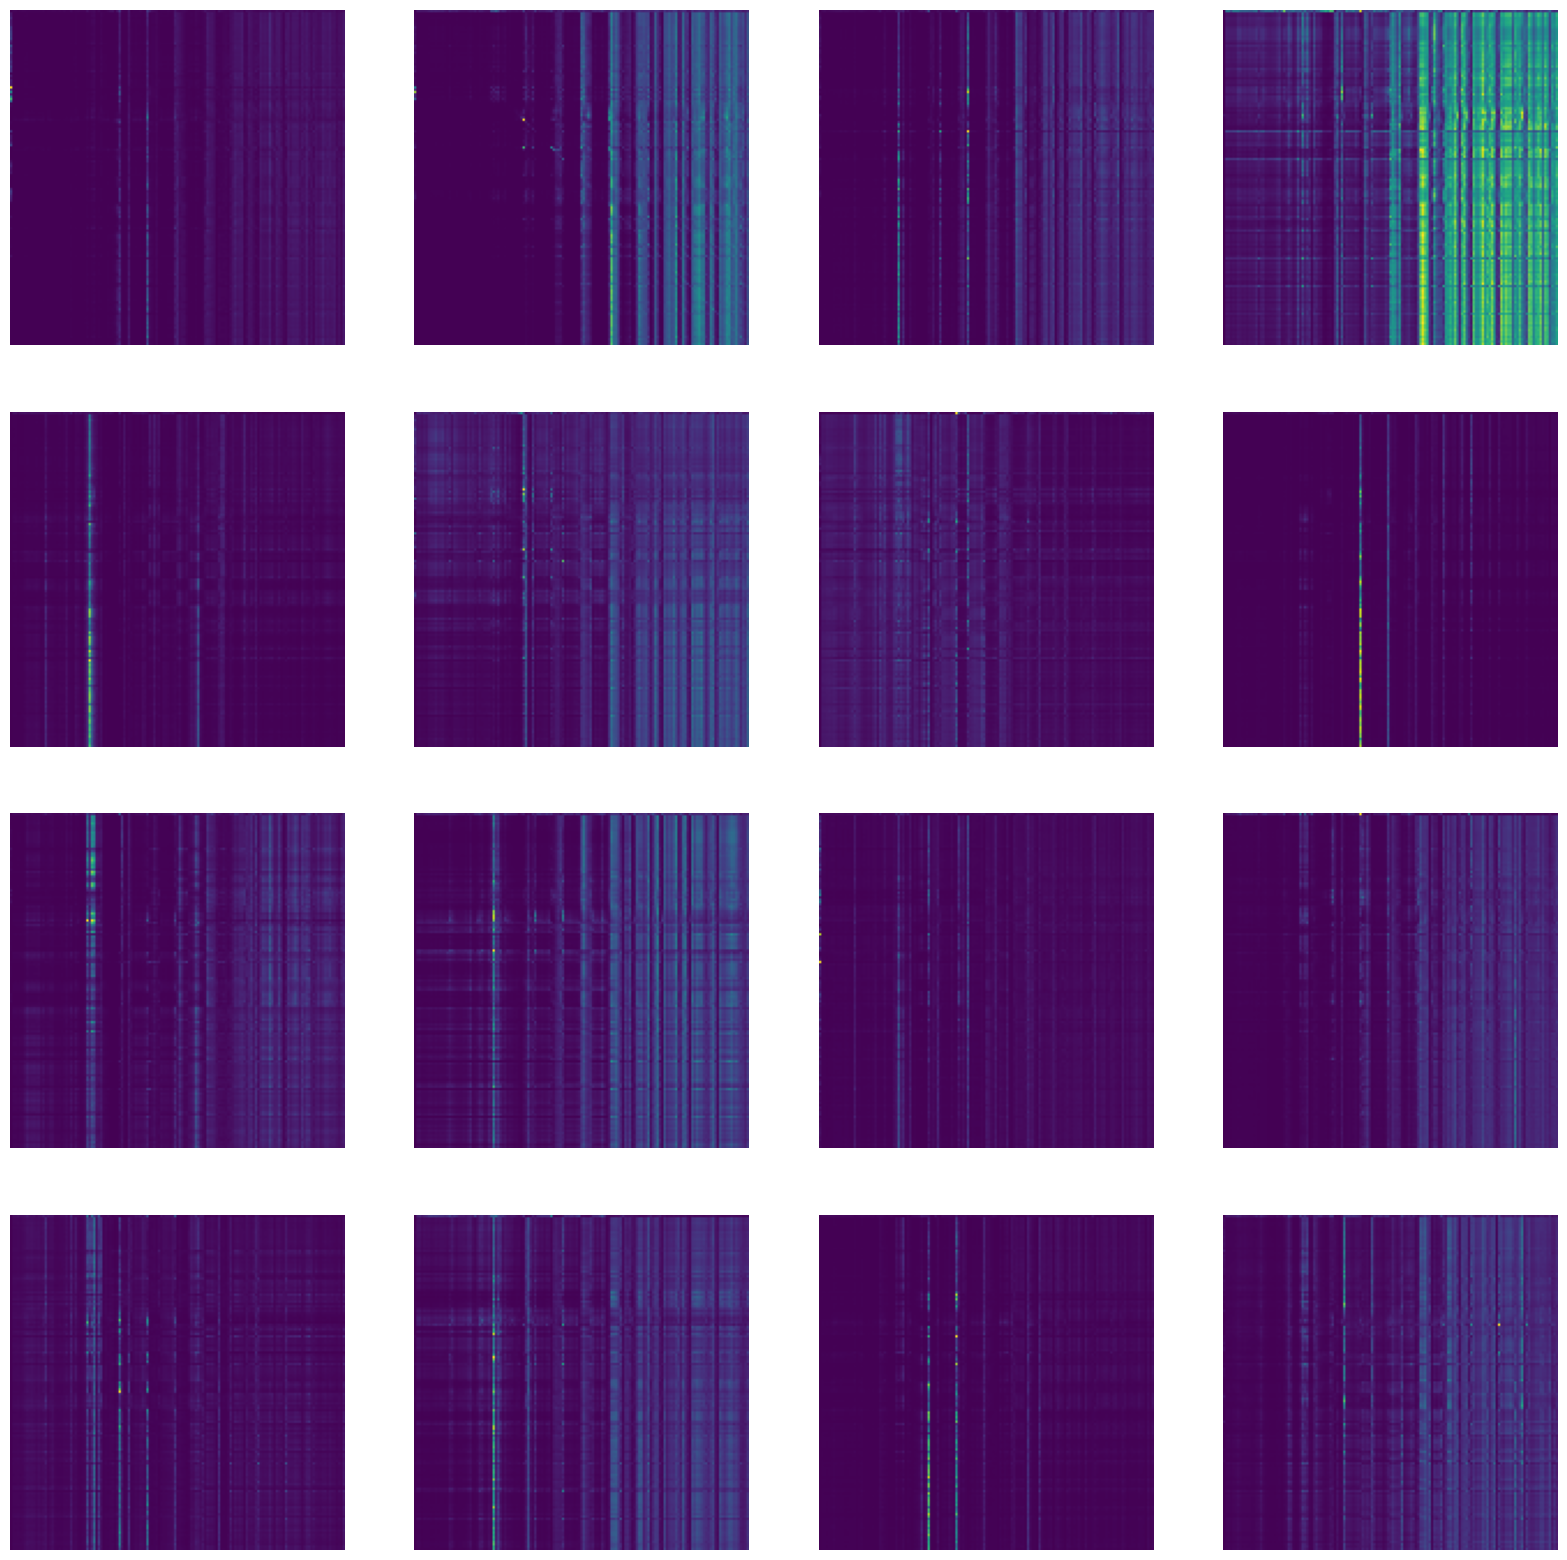

In [ ]:
ig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(attentions[-1][0, i, :, :].detach().cpu().numpy())
    ax.axis('off')

In [ ]:
def attention_rollout(attentions):
    # Initialize rollout with identity matrix
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)

    # Multiply attention maps layer by layer
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1) # Average attention across heads
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device) # A + I
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True) # Normalizing A
        rollout = torch.matmul(rollout, attention_heads_fused) # Multiplication

    return rollout

In [ ]:
rollout = attention_rollout(attentions)
cls_attention = rollout[0, 1:, 0]  # Get attention values from [CLS] token to all patches
cls_attention = 1 - cls_attention.reshape(12, 12)


In [ ]:
from PIL import Image, ImageFilter
import numpy as np

# Normalize the attention map for better visualization
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

# Resize and blur the attention map
cls_attention_resized = Image.fromarray((cls_attention.detach().numpy() * 255).astype(np.uint8)).resize((500, 500), resample=Image.BICUBIC)
cls_attention_resized = cls_attention_resized.filter(ImageFilter.GaussianBlur(radius=2))

In [ ]:
# Convert the attention map to RGBA
cls_attention_colored = np.array(cls_attention_resized.convert("L"))
cls_attention_colored = np.stack([cls_attention_colored]*3 + [cls_attention_colored], axis=-1)

# Adjust the alpha channel to control brightness
cls_attention_colored_img = Image.fromarray(cls_attention_colored, mode="RGBA")
cls_attention_colored_img.putalpha(100)  # Adjust alpha for blending (lower value for darker overlay)

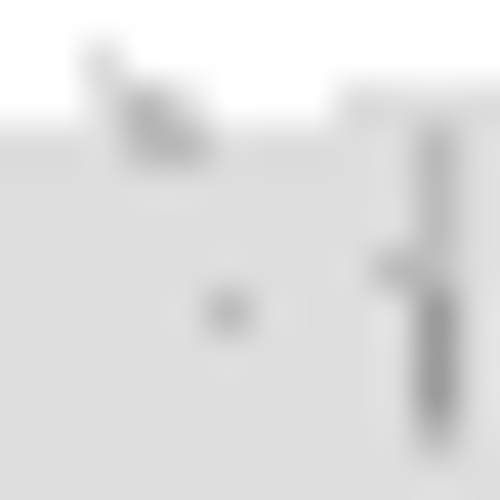

In [ ]:
cls_attention_colored_img